In [1]:
import time
import numpy as np
import os.path as op
import pandas as pd
import scipy.optimize as so
import pickle

import matplotlib.pyplot as plt

from scipy import stats


# model packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns


# statsmodels
import statsmodels.api as sm
import statsmodels.tools as sd

#### 0. Load and format the pupil and behavioral data

In [4]:
# import all pkl files 

# get the project directory (cbandit)
proj_dir = os.path.normpath(os.getcwd()) #+ os.sep + os.pardir)
print(f'project directory: {proj_dir}')

f_pupil = open(proj_dir+"/pupil_epochs_all_new2.pkl","rb")
pupil_data_holder = pickle.load(f_pupil)

f_behavioral = open(proj_dir+"/behavioral_data_cleaned.pkl","rb")
behavioral_data_holder = pickle.load(f_behavioral)

f_model = open(proj_dir+"/model_based_variables.pkl","rb")
model_data_holder = pickle.load(f_model)

data_ff = pd.read_pickle('outputs_ff.p')
valid_sub = np.array(data_ff['subnums'])[:-2]
valid_sub = np.delete(valid_sub, np.where(valid_sub == 35)[0][0])

valid_sub_new = np.delete(valid_sub, [17,18]) # delete sub 24, 25
valid_sub_new_new = np.delete(valid_sub_new, 23)
valid_sub_new_new


nsess = 8

print('number of valid subjects: ', len(valid_sub_new_new))
print('valid subjects: ', valid_sub_new_new)

print('invalid sessions: subject 24, sess 6; subject 34, sess 8')
        #if sub+1 == 24 and sess+1 == 6:
        #    continue
        #if sub+1 == 34 and sess+1 == 8:
        #    continue

project directory: /Users/zoehe/Documents/GitHub/cbandit_23
number of valid subjects:  48
valid subjects:  [ 1  2  3  4  6  8 10 11 12 13 14 16 19 20 21 22 23 26 27 28 29 30 31 33
 34 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
invalid sessions: subject 24, sess 6; subject 34, sess 8


In [14]:
pupil_data_holder['sub1']['sess1'].columns

Index(['trial', 'rt', 'pupil_baseline_start', 'pupil_baseline_outcome',
       'pupil_size_pre_response', 'pupil_size_avg_pre_response',
       'pupil_size_response', 'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3'],
      dtype='object')

In [15]:
behavioral_data_holder['sub1']['sess1'].columns

Index(['trial', 'choices', 'choices_new', 'outcomes', 'mean_A', 'mean_B',
       'mean_chosen', 'mean_unchosen', 'forced', 'free', 'valid', 'SD',
       'changepoints'],
      dtype='object')

In [16]:
model_data_holder['sub1']['sess1'].columns

Index(['trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen_after', 'UU_chosen_before',
       'UU_chosen_after', 'ER_sum_before', 'ER_sum_after', 'EU_sum_before',
       'EU_sum_after', 'UU_sum_before', 'UU_sum_after', 'ER_diff_before',
       'ER_diff_after', 'EU_diff_before', 'EU_diff_after', 'UU_diff_before',
       'UU_diff_after'],
      dtype='object')

Other things to add after filtering:
1. determine whether each trial is a 'switch' or 'stay' choice
2. determine whether the NEXT trial is a switch or stay choice
3. determine whether the current observation has increased or decreased outcome

1. find the observed changepoint (aka: current trial = stay, changepoint = True)
2. find the high-to-low changepoint (aka: decreased outcome = True, changepoint = True)
3. find the trial_after_forced
4. find the trial_after_cp

##### Helper functions

In [ ]:

def trial_after_forced(forced_arr):
    to_return = np.zeros(len(forced_arr))
    count = 0
    for i in range(len(forced_arr)):
        if forced_arr[i]:
            to_return[i] = 0
            count = 0
        else:
            count += 1
            to_return[i] = count
            
    return to_return.astype(int)


def trial_after_cp(cp_arr):
    to_return = np.zeros(len(cp_arr))
    
    count = 0
    for i in range(len(cp_arr)):
        if cp_arr[i]:
            count = 1
        
        to_return[i] = count
        
        if count >= 1:
            count += 1
            
    return to_return.astype(int)

def outcome_change(outcome_arr):
   
    increase_from_last = np.array([outcome_arr[i] - outcome_arr[i-1] for i in range(1, len(outcome_arr))])
    increase_from_last = np.insert(increase_from_last, 0, outcome_arr[0])
    
    return increase_from_last
    



##### preprocess the data: get joint_data_all

In [18]:
f_data_all = open(proj_dir+"/joint_data_all_new2.pkl","rb")
joint_data_all = pickle.load(f_data_all)


In [20]:
joint_data_all['sub1']['sess1'].head()

,index,trial,rt,pupil_baseline_start,pupil_baseline_outcome,pupil_size_pre_response,pupil_size_avg_pre_response,pupil_size_response,pupil_size_avg_response,pupil_size_outcome,...,ER_diff_after,EU_diff_before,EU_diff_after,UU_diff_before,UU_diff_after,switch,switch_next,outcome_change,trial_after_forced,trial_after_cp
0,0,0,0.873,"[-0.13285487334831725, -0.15435727323074105, -...","[0.07491006887873684, 0.13786000971694218, 0.1...","[0.11437311041501608, 0.10994014858446984, 0.1...",0.279017,"[0.353667051165722, 0.39952404529320773, 0.433...",0.475576,"[0.07491006887873684, 0.13786000971694218, 0.1...",...,-1.095099,0.000000,-0.117293,0.000000,0.000000,False,False,48.0,0,0
1,1,1,0.503,"[0.14530678606560862, 0.1443430154502174, 0.24...","[0.23190501894722576, 0.17961922205809192, 0.1...","[0.34474857188501473, 0.35575292963603705, 0.3...",0.299246,"[0.3427030080472347, 0.3527936049405821, 0.374...",1.147825,"[0.23190501894722576, 0.17961922205809192, 0.1...",...,8.048133,-0.117293,-0.143198,0.000000,0.000000,False,True,22.0,0,0
2,2,2,0.948,"[0.22792893919942742, 0.15482785060969537, 0.1...","[0.1730485920638111, 0.15684330963330576, 0.18...","[-0.5578585701312097, -0.5368051541620953, -0....",-0.249000,"[-0.043562563000114525, -0.010950897831385292,...",-0.182329,"[0.1730485920638111, 0.15684330963330576, 0.18...",...,-5.927476,0.143198,-0.013064,0.000000,-0.006041,True,False,-20.0,0,0
3,3,3,0.633,"[-0.04115643605480424, -0.011971396588699315, ...","[-0.02837186777614119, 0.004751287527410095, 0...","[0.9398780279838435, 0.9354819044102489, 0.927...",0.780104,"[0.6531173173194468, 0.6612715975477902, 0.646...",0.399992,"[-0.02837186777614119, 0.004751287527410095, 0...",...,12.144066,-0.013064,-0.420074,-0.006041,0.022409,False,False,50.0,0,0
4,4,4,1.754,"[0.7752312920948785, 0.8033788108457145, 0.831...","[0.467254551806917, 0.46196730826422516, 0.473...","[0.13627293908167493, 0.0938579818830942, 0.08...",-0.051292,"[-0.1988164400882881, -0.1855046140065632, -0....",0.438572,"[0.467254551806917, 0.46196730826422516, 0.473...",...,10.643953,-0.420074,-0.341523,0.022409,-0.011922,False,False,-41.0,1,0


In [22]:
# rank the forced trials:

for sub in valid_sub-1:
    joint_data_each_sub = pd.DataFrame()
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue
            
        sample_data = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']
        test_forced = sample_data['forced']
        
        forced_num = np.zeros(len(test_forced))

        count = 0
        for i in range(len(test_forced)):
            if test_forced[i]:
                count += 1
            else:
                count = 0

            forced_num[i] = count
        
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_forced'] = forced_num.astype(int)
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_num'] = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['index']

In [23]:
# 1. combine across sessions for each subject
joint_data_by_sub = {}
for sub in valid_sub-1:
    joint_data_each_sub = pd.DataFrame()
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue
            
        sample_data = joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']
        sample_data['RPE_before'] = np.insert(sample_data['RPE'].to_numpy(), 0, 0)[:-1]
        sample_data['sess'] = (np.ones(len(sample_data)) * (sess+1)).astype(int)

        joint_data_each_sub = pd.concat([joint_data_each_sub, sample_data], axis=0)
    
    joint_data_each_sub = joint_data_each_sub.reset_index()
    joint_data_by_sub[f'sub{sub+1}'] = joint_data_each_sub

In [ ]:
# create a binary pickle file 
f = open("joint_data_all_new3.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(joint_data_all,f)

# close file
f.close()

# create a binary pickle file 
f2 = open("joint_data_by_sub.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(joint_data_by_sub,f2)

# close file
f2.close()


In [ ]:
# there are two ways of computing the average:
# 1) ignore the effect of sessions; for each subject, compute the average for all trials (n=# subjects)
# 2) ignore the effect of subjects; compute the average across all sessions (n=# sessions)


# concatenate all three
nsess = 8
countt = 0
joint_data_all = {}
for sub in valid_sub-1:
    joint_data_all[f'sub{sub+1}'] = {}
    for sess in range(nsess):
        if sub+1 == 24 and sess+1 == 6:
            continue
        if sub+1 == 34 and sess+1 == 8:
            continue

        countt += 1

        # get the data for each subject, each session
        pupil_data = pupil_data_holder[f'sub{sub+1}'][f'sess{sess+1}']
        behavioral_data = behavioral_data_holder[f'sub{sub+1}'][f'sess{sess+1}']
        model_data = model_data_holder[f'sub{sub+1}'][f'sess{sess+1}']

        # get the RT for the next trial
        rt_next = np.array(pupil_data['rt'][1:]) 
        rt_next = np.insert(rt_next, len(rt_next), np.nan)
        pupil_data['rt_next'] = rt_next
        

     
        
        # TODO: fix the behavioral data first
        # concatenate with behavioral data
        #behavioral_sub = data_list[sub]
        #behavioral_example = behavioral_sub[behavioral_sub['sess']==1]
        #behavioral_example

        joint_data = pd.concat([pupil_data, behavioral_data, model_data], axis=1)
        joint_data = joint_data[joint_data['valid']==True].reset_index()
        
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}'] = joint_data

        # check the number of invalid trials for each session
        k = len(joint_data_all[f'sub{sub+1}'][f'sess{sess+1}'])
        if k < 96:
            print(f'sub{sub+1} sess{sess+1} has {k} invalid trials.')
        
        
        
        # switch, switch_next
        
        # identify the switch trial
        choices_temp = joint_data['choices']
        # all the switches (including the forced trials)
        switch_list = ~np.array([(i==0 or choices_temp[i] == choices_temp[i-1]) for i in range(len(choices_temp))]) #* args['kept']
        switch_next_list = ~np.array([(i==len(choices_temp)-1 or choices_temp[i] == choices_temp[i+1]) for i in range(len(choices_temp))])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['switch'] = switch_list
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['switch_next'] = switch_next_list
        
        # outcome change
        outcome_change_list = outcome_change(joint_data['outcomes'])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['outcome_change'] = outcome_change_list
        
        # find observed changepoints: changepoint == True, switch_list == False
        #observed_changepoints = ~switch_list * joint_data['changepoints']
        
        # find trial_after_forced
        num_trial_after_forced = trial_after_forced(joint_data['forced'])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_after_forced'] = num_trial_after_forced
        
        # find trial after cp
        num_trial_after_cp = trial_after_cp(joint_data['changepoints'])
        joint_data_all[f'sub{sub+1}'][f'sess{sess+1}']['trial_after_cp'] = num_trial_after_cp
        
        

data_ff (Alex) columns:  dict_keys(['subnums', 'subids', 'paramnames', 'parampairnames', 'tp_idx', 'params', 'params_raw', 'params_gt10', 'mdl_accuracy', 'params_alldata', 'nobs', 'reg_avg', 'reg_std', 'reg_cor', 'params_avg', 'params_ste', 'mdl_accuracy_avg', 'mdl_accuracy_ste', 'nobs_avg', 'reg_avg_avg', 'reg_std_avg', 'reg_cor_avg', 'reg_avg_ste', 'reg_std_ste', 'reg_cor_ste'])
vol min:  0.006071067149682751
vol max:  0.4554553707245781


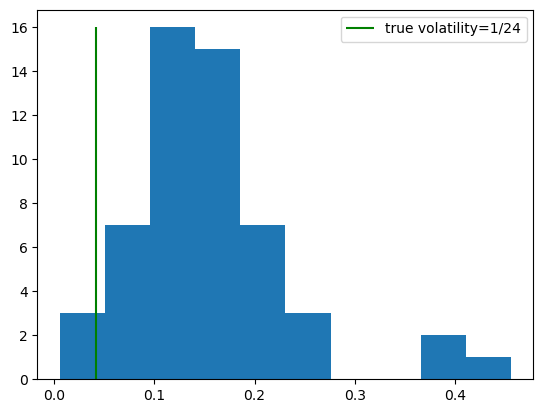

TtestResult(statistic=9.832009601399655, pvalue=1.5163785428351054e-13, df=53)

In [9]:
print('data_ff (Alex) columns: ', data_ff.keys())
print('vol min: ', data_ff['params_alldata']['vol'].to_numpy().flatten().min())
print('vol max: ', data_ff['params_alldata']['vol'].to_numpy().flatten().max())

arr = np.sort(data_ff['params_alldata']['vol'].to_numpy().flatten())
plt.hist(arr)
plt.vlines(x=1/24, ymin=0, ymax=16, label='true volatility=1/24', color='green')
plt.legend()
plt.show()
stats.ttest_1samp(arr, 1/24)